### Importing essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from textblob import TextBlob
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\ASWANI
[nltk_data]     NM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASWANI
[nltk_data]     NM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Load the data
data = pd.read_csv('sentimentalds.csv')
df = pd.read_csv('sentimentalds.csv')

In [4]:
df

Unnamed: 0                                          statement   status
0               0                                         oh my gosh  Anxiety
1               1  trouble sleeping, confused mind, restless hear...  Anxiety
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3               3  I've shifted my focus to something else but I'...  Anxiety
4               4  I'm restless and restless, it's been a month n...  Anxiety
...           ...                                                ...      ...
46291       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
46292       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
46293       53040  Is there any way to sleep better? I can't slee...  Anxiety
46294       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
46295       53042  I have really bad door anxiety! It's not about...  Anxiety

[46296 rows x 3 columns]

In [5]:
# Display the first few rows of the dataframe
df.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [6]:
df.tail()

Unnamed: 0                                          statement   status
46291       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety
46292       53039  selfishness  "I don't feel very good, it's lik...  Anxiety
46293       53040  Is there any way to sleep better? I can't slee...  Anxiety
46294       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
46295       53042  I have really bad door anxiety! It's not about...  Anxiety

### Exploratory Data Analysis(EDA)

In [7]:
# Exploratory Data Analysis(EDA)
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46296 entries, 0 to 46295
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  46296 non-null  int64 
 1   statement   46240 non-null  object
 2   status      46296 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [8]:
df.shape

(46296, 3)

In [9]:
df['status'].nunique()

4

In [10]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Unnamed: 0     0
statement     56
status         0
dtype: int64


In [11]:
# Handle NaN values in the statement column
df['statement'] = df['statement'].fillna('')

In [12]:
df.isnull().sum()

Unnamed: 0    0
statement     0
status        0
dtype: int64

In [13]:
sentiment_counts=df['status'].value_counts()
print(sentiment_counts)

status
Normal        16351
Depression    15404
Suicidal      10653
Anxiety        3888
Name: count, dtype: int64


In [14]:
import seaborn as sns

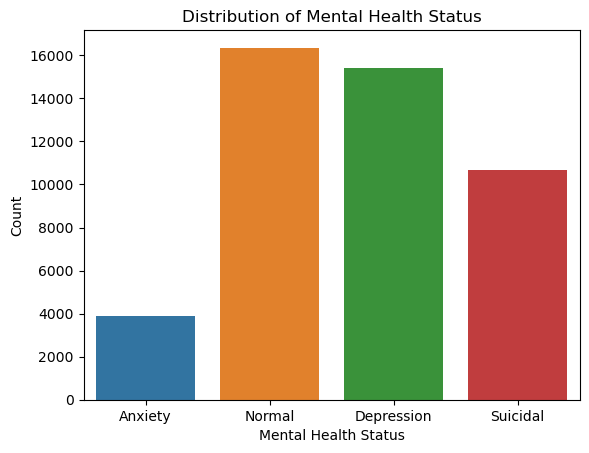

In [15]:
sns.countplot(data=df, x='status',hue="status")
plt.title('Distribution of Mental Health Status')
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.show()

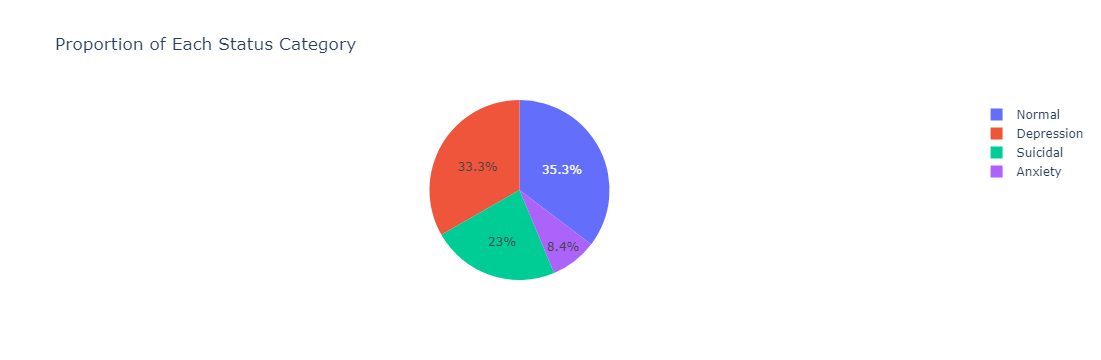

In [16]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()

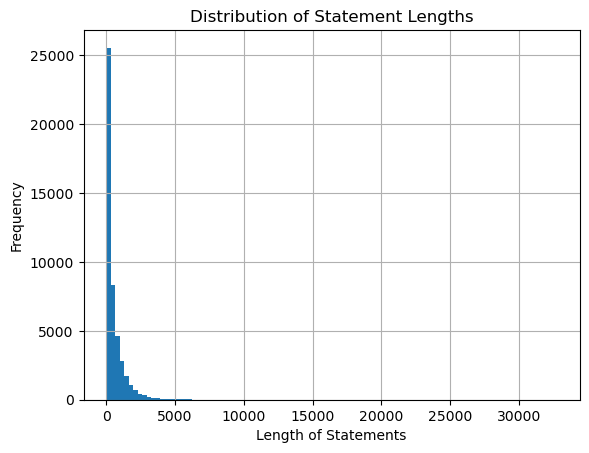

In [17]:
# Calculate the length of each statement
df['statement_length'] = df['statement'].apply(len)

# Display basic statistics of statement lengths
#print(df['statement_length'].describe())

# Plot the distribution of statement lengths
df['statement_length'].hist(bins=100)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

### Data Preprocessing

In [18]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

### Tokenization and Stopwords Removal

In [19]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

### Data Augmentation

In [20]:
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df['statement'].apply(augment_text)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augmented_statement']
df = pd.concat([df, augmented_df])

In [21]:
# Reapply preprocessing on augmented data
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [22]:
# Ensure no NaN values are left
df['cleaned_statement'] = df['cleaned_statement'].fillna('')

In [23]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Text Vectorization

In [25]:
vectorizer = TfidfVectorizer(max_features=10000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Decision Tree Classifier

In [26]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [0.01, 0.1, 1, 10, 100]
}
model = DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [27]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [28]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

accuracy = round(accuracy_score(y_test, y_pred), 3)
print(f'Accuracy of the model: {accuracy}')


print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'criterion': 'entropy', 'max_depth': 100}
Accuracy of the model: 0.931
Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.93      0.90      0.92      1563
  Depression       0.92      0.92      0.92      6203
      Normal       0.94      0.98      0.96      6447
    Suicidal       0.92      0.88      0.90      4306

    accuracy                           0.93     18519
   macro avg       0.93      0.92      0.93     18519
weighted avg       0.93      0.93      0.93     18519



### Decision Tree classifier has an accuracy of almost 0.93. It also performed better than the naive bayes classifier.

In [29]:
sampletext = ["waiting for uncertainty, please be anxious"]
xnew_tfidf = vectorizer.transform(sampletext)
prediction = best_model.predict(xnew_tfidf)
prediction

array(['Anxiety'], dtype=object)

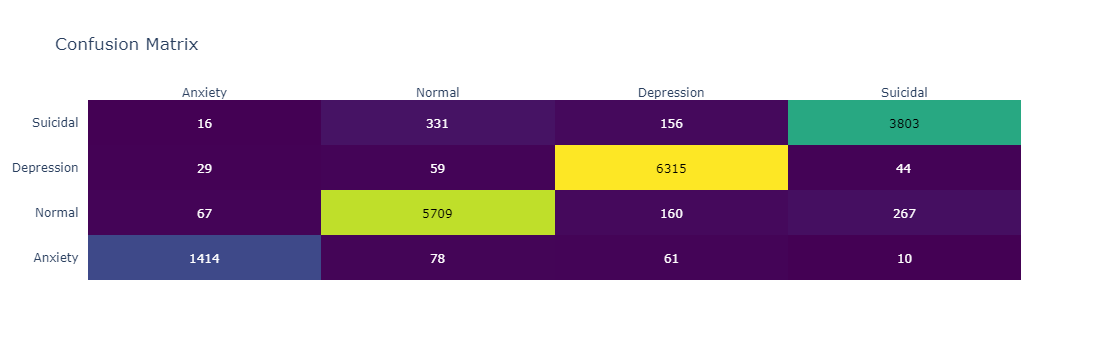

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()

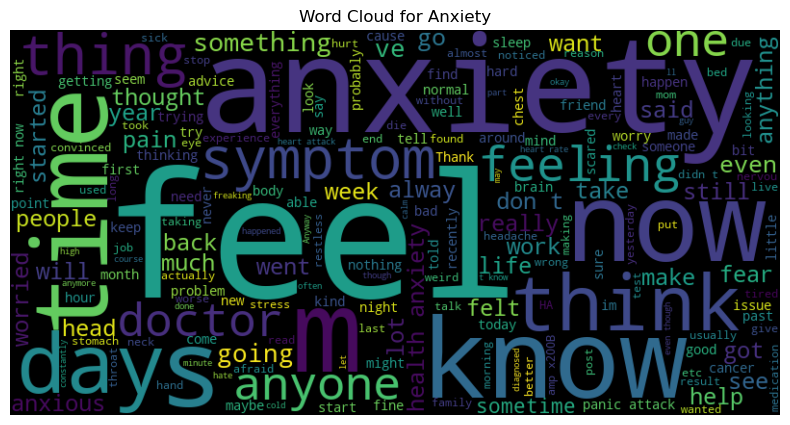

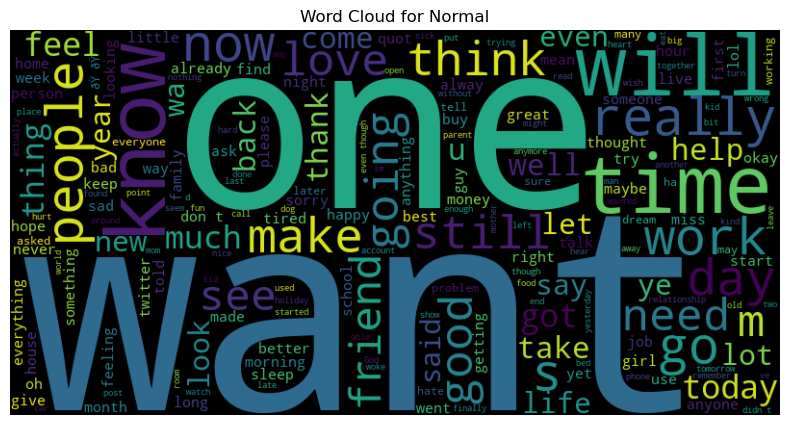

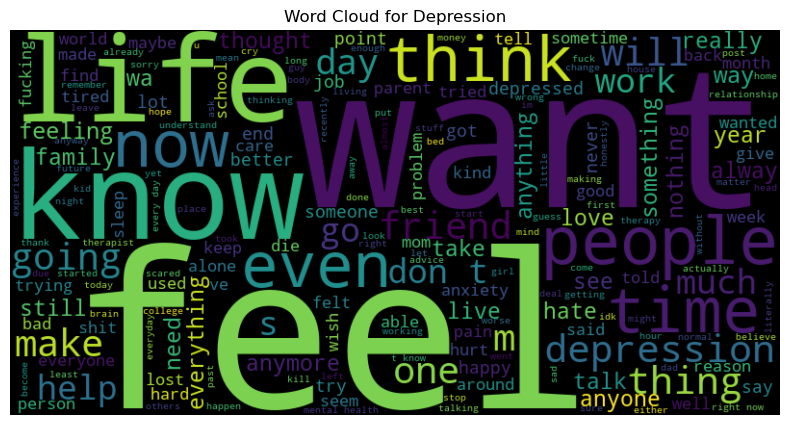

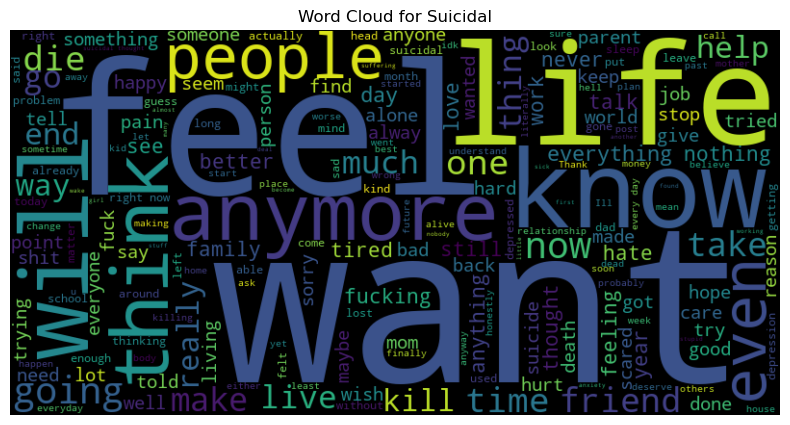

In [31]:
# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each status
statuses = df['status'].unique()

for status in statuses:
    status_text = ' '.join(df[df['status'] == status]['statement'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')


In [31]:
import joblib

### Save the vectorizer and the best model using joblib

In [32]:
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [33]:
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']